In [20]:
from dotenv import load_dotenv
load_dotenv()
import os 
os.environ['GROQ_API_KEY'] = os.getenv("GROQ_API_KEY")
groq_api_key = os.getenv("GROQ_API_KEY")
os.environ['LANGCHAIN_API_KEY'] = os.getenv("LANGCHAIN_API_KEY")
os.environ['TAVILY_API_KEY'] = os.getenv("TAVILY_API_KEY")
os.environ['LANGCHAIN_TRACKING_V2'] = "true"
os.environ['LANGCHAIN_PROJECT'] = "rough_trail_langgraph"

In [21]:
from langchain_groq import ChatGroq
llm = ChatGroq(model="openai/gpt-oss-120b", api_key=groq_api_key)
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x109523260>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x1093f59d0>, model_name='openai/gpt-oss-120b', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [22]:
llm.invoke("who are you")

AIMessage(content='I’m ChatGPT, a large language model created by OpenAI. I’m here to help answer questions, provide information, and assist with a wide range of topics. Let me know how I can help!', additional_kwargs={'reasoning_content': 'The user asks "who are you". They want a short answer. As ChatGPT, we should respond with identity: ChatGPT, a large language model trained by OpenAI, etc. No disallowed content. Provide a brief answer.'}, response_metadata={'token_usage': {'completion_tokens': 100, 'prompt_tokens': 74, 'total_tokens': 174, 'completion_time': 0.180213383, 'prompt_time': 0.004356096, 'queue_time': 0.043632576, 'total_time': 0.184569479}, 'model_name': 'openai/gpt-oss-120b', 'system_fingerprint': 'fp_82669fd91d', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--561d8544-82e0-4c86-b0f8-f3927a74c92f-0', usage_metadata={'input_tokens': 74, 'output_tokens': 100, 'total_tokens': 174})

In [23]:
## adding tools
from langchain_community.tools import WikipediaQueryRun, ArxivQueryRun
from langchain_community.utilities import WikipediaAPIWrapper, ArxivAPIWrapper
from langchain_community.tools.tavily_search import TavilySearchResults

# tool wrapper
wiki_wrapper = WikipediaAPIWrapper(top_k_results=2, doc_content_chars_max=250)
arxiv_wrapper = ArxivAPIWrapper(top_k_results=2, doc_content_chars_max=250)

## initializing tools
wiki = WikipediaQueryRun(api_wrapper=wiki_wrapper)
arxiv = ArxivQueryRun(api_wrapper=arxiv_wrapper)

# websearch browser
tavily = TavilySearchResults()


### custom tools
def add(a:int, b:int)->int:
    """ add a and b
    Args:
        a: first int
        b: second int
    """
    return a + b


def subtract(a:int, b:int)->int:
    """ subtract a and b
    Args:
        a: first int
        b: second int
    """
    return a - b


def multiply(a:int, b:int)->int:
    """ multiply a and b
    Args:
        a: first int
        b: second int
    """
    return a * b



def divide(a:int, b:int)->int:
    """ divide a and b
    Args:
        a: first int
        b: second int
    """
    return a / b

In [24]:
tools = [wiki, arxiv, tavily, add, subtract, multiply, divide]

In [25]:
## binding tools with llm
llm = llm.bind_tools(tools)

In [26]:
## state for the graph
from typing_extensions import TypedDict
from typing import Literal, Annotated
from langgraph.graph import add_messages
from pydantic import BaseModel
from langchain_core.messages import AnyMessage

class State(BaseModel):
    messages: Annotated[list[AnyMessage], add_messages]

In [27]:
def super_bot(state:State):
    return {"messages": llm.invoke(state.messages)}

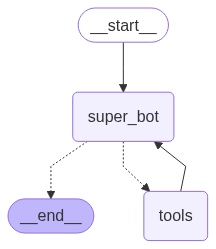

In [43]:
## building the state graph
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import tools_condition, ToolNode

graph_builder = StateGraph(State)
# adding nodes to the graph
graph_builder.add_node("super_bot", super_bot)
graph_builder.add_node("tools", ToolNode(tools))

# adding edges to the graph
graph_builder.add_edge(START, "super_bot")
graph_builder.add_conditional_edges("super_bot", tools_condition)
graph_builder.add_edge("tools", "super_bot")

# compiling the graph with check point
from langgraph.checkpoint.memory import MemorySaver
graph_memory = MemorySaver()
graph = graph_builder.compile(checkpointer=graph_memory)

# displaying the graph
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [61]:
from langchain_core.messages import HumanMessage
from pprint import pprint
config1 = {"configurable":{"thread_id":"1"}}
config2 = {"configurable":{"thread_id":"2"}}
config3 = {"configurable":{"thread_id":"3"}}
config4 = {"configurable":{"thread_id":"4"}}
config5 = {"configurable":{"thread_id":"5"}}
config6 = {"configurable":{"thread_id":"6"}}
config7 = {"configurable":{"thread_id":"7"}}
config8 = {"configurable":{"thread_id":"8"}}
config9 = {"configurable":{"thread_id":"9"}}

In [49]:
msgs = graph.invoke({"messages": HumanMessage(content="give results from wikipedia about him")}, config=config1)
for msg in msgs['messages']:
    msg.pretty_print()


================================ Human Message =================================

who are you?
================================== Ai Message ==================================

I’m ChatGPT, a large language model created by OpenAI. I’ve been trained on a wide variety of text so I can help answer questions, explain concepts, brainstorm ideas, write and edit all sorts of content, troubleshoot problems, and much more. Think of me as a knowledgeable, text‑based assistant that’s here to chat, provide information, and help you with whatever you need—whether it’s a quick fact, a deep dive into a topic, or a little creative inspiration. How can I help you today?
================================ Human Message =================================

what is the current year
================================== Ai Message ==================================

The current year is **2025**.
================================ Human Message =================================

what is the current date
===========

In [52]:

for msg in graph.stream({"messages": HumanMessage(content="give results from wikipedia about him")}, config=config1):
    print(msg)

{'super_bot': {'messages': AIMessage(content='', additional_kwargs={'reasoning_content': 'The user asks again "give results from wikipedia about him". The previous answer gave summaries from Wikipedia for Goku and Bardock. The user likely wants the full Wikipedia article or a more detailed excerpt. We can retrieve the Wikipedia page content. Use wikipedia tool with query "Goku". The earlier call gave summary only. We may need to get more content. Possibly request more details. Let\'s fetch full article.', 'tool_calls': [{'id': 'fc_5b4dc979-5980-4f2c-afd4-1549fa0c4b62', 'function': {'arguments': '{"query":"Goku"}', 'name': 'wikipedia'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 103, 'prompt_tokens': 2012, 'total_tokens': 2115, 'completion_time': 0.185820889, 'prompt_time': 0.072640211, 'queue_time': 0.044021063, 'total_time': 0.2584611}, 'model_name': 'openai/gpt-oss-120b', 'system_fingerprint': 'fp_82669fd91d', 'service_tier': 'on_demand', 'finish_r

In [53]:

for msg in graph.stream({"messages": HumanMessage(content="2 plus 2")}, config=config1, stream_mode="values"):
    print(msg)

{'messages': [HumanMessage(content='who are you?', additional_kwargs={}, response_metadata={}, id='cb808076-f4cf-470b-9a08-da221eb8940c'), AIMessage(content='I’m ChatGPT, a large language model created by OpenAI. I’ve been trained on a wide variety of text so I can help answer questions, explain concepts, brainstorm ideas, write and edit all sorts of content, troubleshoot problems, and much more. Think of me as a knowledgeable, text‑based assistant that’s here to chat, provide information, and help you with whatever you need—whether it’s a quick fact, a deep dive into a topic, or a little creative inspiration. How can I help you today?', additional_kwargs={'reasoning_content': 'The user asks "who are you?" Probably they want a description of the assistant. Provide a friendly answer.'}, response_metadata={'token_usage': {'completion_tokens': 139, 'prompt_tokens': 445, 'total_tokens': 584, 'completion_time': 0.250403413, 'prompt_time': 0.017428745, 'queue_time': 0.049445602, 'total_time'

In [54]:
for msg in graph.stream({"messages": HumanMessage(content="2 plus 3")}, config=config1, stream_mode="updates"):
    print(msg)

{'super_bot': {'messages': AIMessage(content='2\u202f+\u202f3\u202f=\u202f5.', additional_kwargs={'reasoning_content': 'User asks "2 plus 3". Simple addition. Provide answer.'}, response_metadata={'token_usage': {'completion_tokens': 34, 'prompt_tokens': 4086, 'total_tokens': 4120, 'completion_time': 0.061435393, 'prompt_time': 0.147201888, 'queue_time': 0.050399012, 'total_time': 0.208637281}, 'model_name': 'openai/gpt-oss-120b', 'system_fingerprint': 'fp_8db49de948', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--d110ae80-f4c6-48c6-8179-c32cebcaeeac-0', usage_metadata={'input_tokens': 4086, 'output_tokens': 34, 'total_tokens': 4120})}}


In [58]:
from langchain_core.messages import AnyMessage, AIMessage, HumanMessage
messages1=[AIMessage(content=f"Please tell me how can I help",name="LLMModel")]
messages1.append(HumanMessage(content=f"I want to learn coding",name="pavi"))
messages1.append(AIMessage(content=f"Which programming language you want to learn",name="LLMModel"))
messages1.append(HumanMessage(content=f"I want to learn python programming language",name="pavi"))
for msg in graph.stream({"messages": messages1}, config=config2):
    print(msg)

{'super_bot': {'messages': AIMessage(content='Great! Python is an excellent choice for beginners (and also a powerful tool for many advanced applications). Below is a **step‑by‑step learning roadmap** that you can follow at your own pace, plus **free resources**, **practice ideas**, and **tips** to keep you motivated.\n\n---\n\n## 1️⃣ Set Up Your Development Environment (Day\u202f1‑2)\n\n| Step | What to Do | Why It Matters | Quick Resources |\n|------|-----------|----------------|----------------|\n| **Install Python** | Download the latest stable version (3.11+ as of 2025) from <https://python.org/downloads>. Choose the “Add Python to PATH” option during installation. | Gives you a working interpreter. | Official installer |\n| **Choose an IDE / Editor** | • **VS\u202fCode** (free, extensions for Python, linting, debugging) <br>• **PyCharm Community** <br>• **Jupyter Notebook** (great for interactive learning) | A good editor makes coding smoother. | VS\u202fCode download page; Jupyt

In [62]:
from langchain_core.messages import AnyMessage, AIMessage, HumanMessage
messages1=[AIMessage(content=f"Please tell me how can I help",name="LLMModel")]
messages1.append(HumanMessage(content=f"I want to learn coding",name="pavi"))
messages1.append(AIMessage(content=f"Which programming language you want to learn",name="LLMModel"))
messages1.append(HumanMessage(content=f"I want to learn python programming language",name="pavi"))
for msg in graph.stream({"messages": messages1}, config=config3, stream_mode="values"):
    print(msg)

{'messages': [AIMessage(content='Please tell me how can I help', additional_kwargs={}, response_metadata={}, name='LLMModel', id='c66cf9c8-8305-4e34-ba25-507191cc28b8'), HumanMessage(content='I want to learn coding', additional_kwargs={}, response_metadata={}, name='pavi', id='724ae098-7452-4708-9ea7-58f425f8c7f1'), AIMessage(content='Which programming language you want to learn', additional_kwargs={}, response_metadata={}, name='LLMModel', id='d0b396ee-1d25-4c1b-9ab4-1e221723d050'), HumanMessage(content='I want to learn python programming language', additional_kwargs={}, response_metadata={}, name='pavi', id='206806b9-26eb-4bb1-8964-b029c7cf70b6'), AIMessage(content='Great! Python is an excellent choice for beginners (and also a powerful tool for many advanced applications). Below is a **step‑by‑step learning roadmap** that you can follow at your own pace, plus **free resources**, **practice ideas**, and **tips** to keep you motivated.\n\n---\n\n## 1️⃣ Set Up Your Development Environm

In [63]:
from langchain_core.messages import AnyMessage, AIMessage, HumanMessage
messages1=[AIMessage(content=f"Please tell me how can I help",name="LLMModel")]
messages1.append(HumanMessage(content=f"I want to learn coding",name="pavi"))
messages1.append(AIMessage(content=f"Which programming language you want to learn",name="LLMModel"))
messages1.append(HumanMessage(content=f"I want to learn python programming language",name="pavi"))
for msg in graph.stream({"messages": messages1}, config=config4, stream_mode="updates"):
    print(msg)

{'super_bot': {'messages': AIMessage(content='Great! Python is an excellent choice for beginners (and also a powerful tool for many advanced applications). Below is a **step‑by‑step learning roadmap** that you can follow at your own pace, plus **free resources**, **practice ideas**, and **tips** to keep you motivated.\n\n---\n\n## 1️⃣ Set Up Your Development Environment (Day\u202f1‑2)\n\n| Step | What to Do | Why It Matters | Quick Resources |\n|------|-----------|----------------|----------------|\n| **Install Python** | Download the latest stable version (3.11+ as of 2025) from <https://python.org/downloads>. Choose the “Add Python to PATH” option during installation. | Gives you a working interpreter. | Official installer |\n| **Choose an IDE / Editor** | • **VS\u202fCode** (free, extensions for Python, linting, debugging) <br>• **PyCharm Community** <br>• **Jupyter Notebook** (great for interactive learning) | A good editor makes coding smoother. | VS\u202fCode download page; Jupyt

In [ ]:
from langchain_core.messages import AnyMessage, AIMessage, HumanMessage
messages1=[AIMessage(content=f"Please tell me how can I help",name="LLMModel")]
messages1.append(HumanMessage(content=f"I want to learn coding",name="pavi"))
messages1.append(AIMessage(content=f"Which programming language you want to learn",name="LLMModel"))
messages1.append(HumanMessage(content=f"I want to learn python programming language",name="pavi"))
for msg in graph.stream({"messages": messages1}, config=config4, stream_mode="updates"):
    print(msg)